In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

# Filtering 1/32 experiment

In [2]:
from dask.diagnostics import ProgressBar

In [3]:
R32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots*', decode_times=False, chunks={'zi':1, 'zl':1, 'time':1}).isel(time=slice(None,None,6))
static = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/static.nc', decode_times=False)
#R32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*', decode_times=False, chunks={'zi':1, 'zl':1, 'time':1})

In [4]:
import gcm_filters
def filter_dataset(ds, static, FGR=4):
    if FGR == 0:
        return ds
    filter_simple_fixed_factor_t = gcm_filters.Filter(
        filter_scale=FGR,
        dx_min=1,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': static.area_t, 'wet_mask': static.wet}
    )

    filter_simple_fixed_factor_u = gcm_filters.Filter(
        filter_scale=FGR,
        dx_min=1,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': static.area_u, 'wet_mask': static.wet_u}
    )

    filter_simple_fixed_factor_v = gcm_filters.Filter(
        filter_scale=FGR,
        dx_min=1,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': static.area_v, 'wet_mask': static.wet_v}
    )
    
    dsf = xr.Dataset()
    dsf['e'] = filter_simple_fixed_factor_t.apply(ds.e.copy(), dims=['yh', 'xh'])
    dsf['h'] = filter_simple_fixed_factor_t.apply(ds.h.copy(), dims=['yh', 'xh'])
    dsf['u'] = filter_simple_fixed_factor_u.apply(ds.u.copy(), dims=['yh', 'xq'])
    dsf['v'] = filter_simple_fixed_factor_v.apply(ds.v.copy(), dims=['yq', 'xh'])
    return dsf

In [5]:
R32f = filter_dataset(R32, static, FGR=16) # Filtering to 1/2 degree resolution

In [6]:
with ProgressBar():
    R32f.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-snapshots.nc')

[########################################] | 100% Completed | 550.28 s


In [7]:
M32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*', decode_times=False, chunks={'zi':1, 'zl':1, 'time':1})

In [8]:
M32f = filter_dataset(M32, static, FGR=16) # Filtering to 1/2 degree resolution

In [9]:
with ProgressBar():
    M32f.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-longmean.nc')

[########################################] | 100% Completed | 16m 13s


# KE/APE for filtered/unfiltered data

In [10]:
R32f_R1 = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', chunks={'zl':1, 'zi':1, 'time':1})
R32f_R2 = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-snapshots.nc', chunks={'zl':1, 'zi':1, 'time':1})
R32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots*', decode_times=False, chunks={'zi':1, 'zl':1, 'time':1}).isel(time=slice(None,None,6))
static = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/static.nc', decode_times=False)

In [12]:
R32f_R1['h'] = e_to_h(R32f_R1.e, R32f_R1.h)
R32f_R2['h'] = e_to_h(R32f_R2.e, R32f_R2.h)

In [11]:
def KE_joul(ds, static):
    u = ds.u
    v = ds.v
    h = ds.h
    R = 1000. # It is reference density
    area_t = static.area_t
    return (0.5 * R * (remesh(u**2, h) + remesh(v**2, h)) * h * area_t).sum(dim=('xh','yh', 'zl'))

def APE_joul(interface, static, eta_above_topography=False, sum=True, bottom='interface'):

    interface_rest = xr.DataArray([    0.,   -25.,   -75.,  -175.,  -300.,  -450.,  -625.,  -825.,
       -1050., -1300., -1600., -1950., -2350., -2850., -3400., -4000.], dims='zi')
    g = xr.DataArray([1.0e+01, 2.1e-03, 3.9e-03, 5.4e-03, 5.8e-03, 5.8e-03, 5.7e-03,
       5.3e-03, 4.8e-03, 4.2e-03, 3.7e-03, 3.1e-03, 2.4e-03, 1.7e-03,
       1.1e-03, 0.0e+00], dims='zi')
    
    R = 1000. # Reference density
    area_t = static.area_t
    if bottom == 'interface':
        coordinate_of_bottom = interface.isel(zi=-1, time=0).drop_vars(['time', 'zi'])
    elif bottom == 'static':
        coordinate_of_bottom = - static.depth_ocean
    else:
        print('Error: wrong bottom parameter')
    
    if eta_above_topography:
        interface = np.maximum(interface, coordinate_of_bottom)
    hint = interface - interface_rest
    
    # Where bottom is upper than the rest interface
    hbot = np.maximum(coordinate_of_bottom - interface_rest,0)
    
    APE_instant = (0.5 * R * g * (hint**2) * area_t)
    APE_constant = (0.5 * R * g * (hbot**2) * area_t)
    if sum:
        return (APE_instant - APE_constant).sum(['zi', 'xh', 'yh'])
    else:
        return (APE_instant - APE_constant)
    
def h_to_e(h, e, static):
    depth = static.depth_ocean
    
    eta = xr.zeros_like(e)
    
    for zl in range(len(h.zl)):
        eta[{'zi': zl}] = h.isel(zl=slice(zl,None)).sum('zl')
    eta = eta - depth
    
    return eta

def e_to_h(e, h):
    thickness = h * 0
    
    for zl in range(len(h.zl)):
        thickness[{'zl':zl}] = e.isel(zi=zl)-e.isel(zi=zl+1)
    
    return thickness

In [7]:
with ProgressBar():
    print('KE in 1/32 experiment = ', float(KE_joul(R32, static).mean()))
    print('KE in 1/32 experiment filtered to 1-degree grid = ', float(KE_joul(R32f, static).mean()))

[########################################] | 100% Completed |  2min 36.5s
KE in 1/32 experiment =  2.4482846764501053e+18
[########################################] | 100% Completed | 28.1s
KE in 1/32 experiment filtered to 1-degree grid =  1.8403431929593664e+18


In [8]:
with ProgressBar():
    print('APE in 1/32 experiment = ', float(APE_joul(R32.e, static).mean()))
    print('APE in 1/32 experiment filtered to 1-degree grid = ', float(APE_joul(R32f.e, static).mean()))

[########################################] | 100% Completed | 50.8s
APE in 1/32 experiment =  9.584091708173936e+19
[########################################] | 100% Completed |  7.9s
APE in 1/32 experiment filtered to 1-degree grid =  8.917282844803611e+19


# APE from h data

In [10]:
R32f = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', decode_times=False)[['h','e']].load()
R32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots*', decode_times=False).isel(time=slice(None,None,6))[['h','e']].load()

In [11]:
static = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/static.nc', decode_times=False).load()

In [16]:
with ProgressBar():
    e = h_to_e(R32.h, R32.e, static).compute()
    ef = h_to_e(R32f.h, R32f.e, static).compute()

In [17]:
with ProgressBar():
    print('APE in 1/32 experiment = ', float(APE_joul(e, static).mean()))
    print('APE in 1/32 experiment filtered to 1-degree grid = ', float(APE_joul(ef, static).mean()))

APE in 1/32 experiment =  9.584091695291267e+19
APE in 1/32 experiment filtered to 1-degree grid =  3.591149681755747e+20


# APE/KE from e data for 1-degree and 1/2-degree

In [16]:
with ProgressBar():
    print('KE in 1/32 experiment = ', float(KE_joul(R32, static).mean()))
    print('KE in 1/32 experiment filtered with 1-degree filter = ', float(KE_joul(R32f_R1, static).mean()))
    print('KE in 1/32 experiment filtered with 0.5-degree filter = ', float(KE_joul(R32f_R2, static).mean()))

[########################################] | 100% Completed | 388.77 s
KE in 1/32 experiment =  2.4482846764501053e+18
[########################################] | 100% Completed | 41.86 s
KE in 1/32 experiment filtered with 1-degree filter =  1.840343192972326e+18
[########################################] | 100% Completed | 41.14 s
KE in 1/32 experiment filtered with 0.5-degree filter =  2.2143647793008573e+18


In [17]:
with ProgressBar():
    print('APE in 1/32 experiment = ', float(APE_joul(R32.e, static).mean()))
    print('APE in 1/32 experiment filtered with 1-degree filter = ', float(APE_joul(R32f_R1.e, static).mean()))
    print('APE in 1/32 experiment filtered with 0.5-degree filter = ', float(APE_joul(R32f_R2.e, static).mean()))

[########################################] | 100% Completed | 140.12 s
APE in 1/32 experiment =  9.584091697350959e+19
[########################################] | 100% Completed | 4.83 sms
APE in 1/32 experiment filtered with 1-degree filter =  9.652627710687404e+19
[########################################] | 100% Completed | 7.26 sms
APE in 1/32 experiment filtered with 0.5-degree filter =  9.584002945213525e+19


# Single plot of filtered fields

In [20]:
R32f = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', decode_times=False).isel(time=-1)
R32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots*.nc', decode_times=False).isel(time=-1)
M32f = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-longmean.nc', decode_times=False).isel(time=-1)
M32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*.nc', decode_times=False).isel(time=-1)

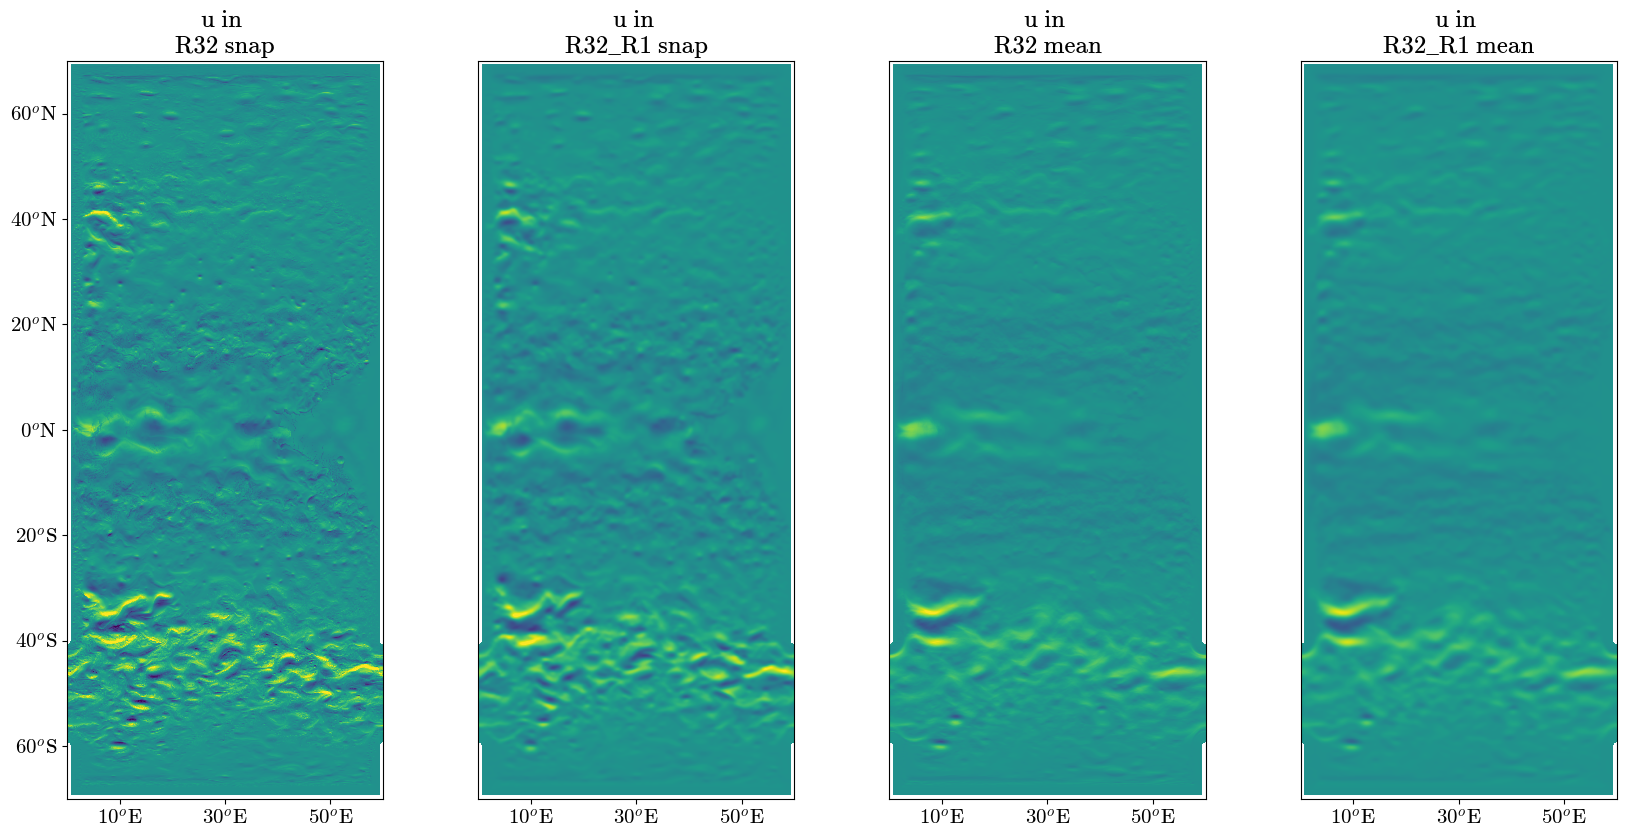

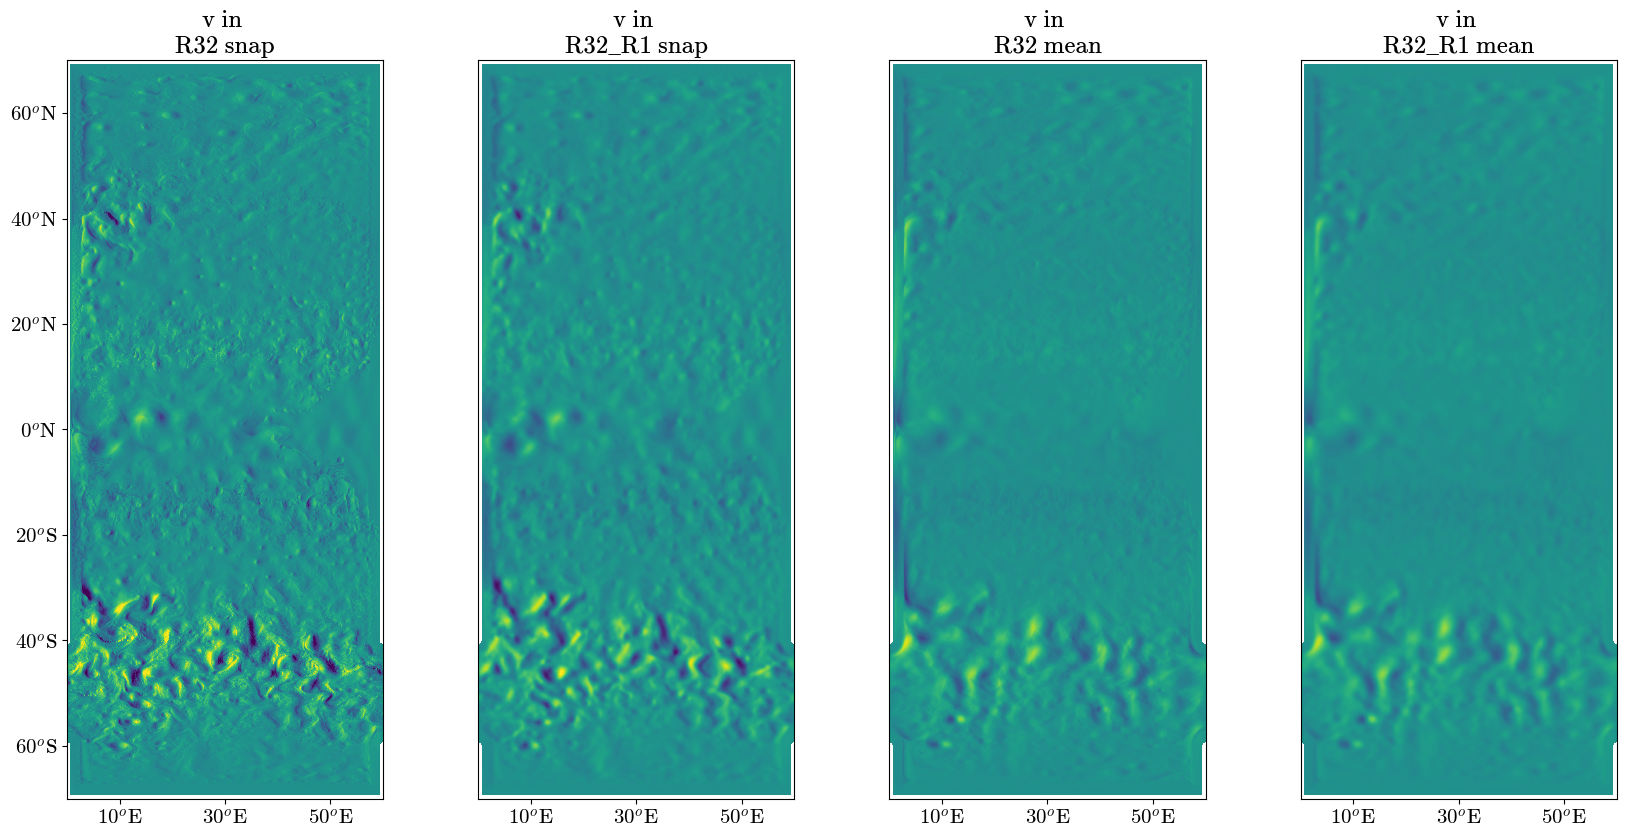

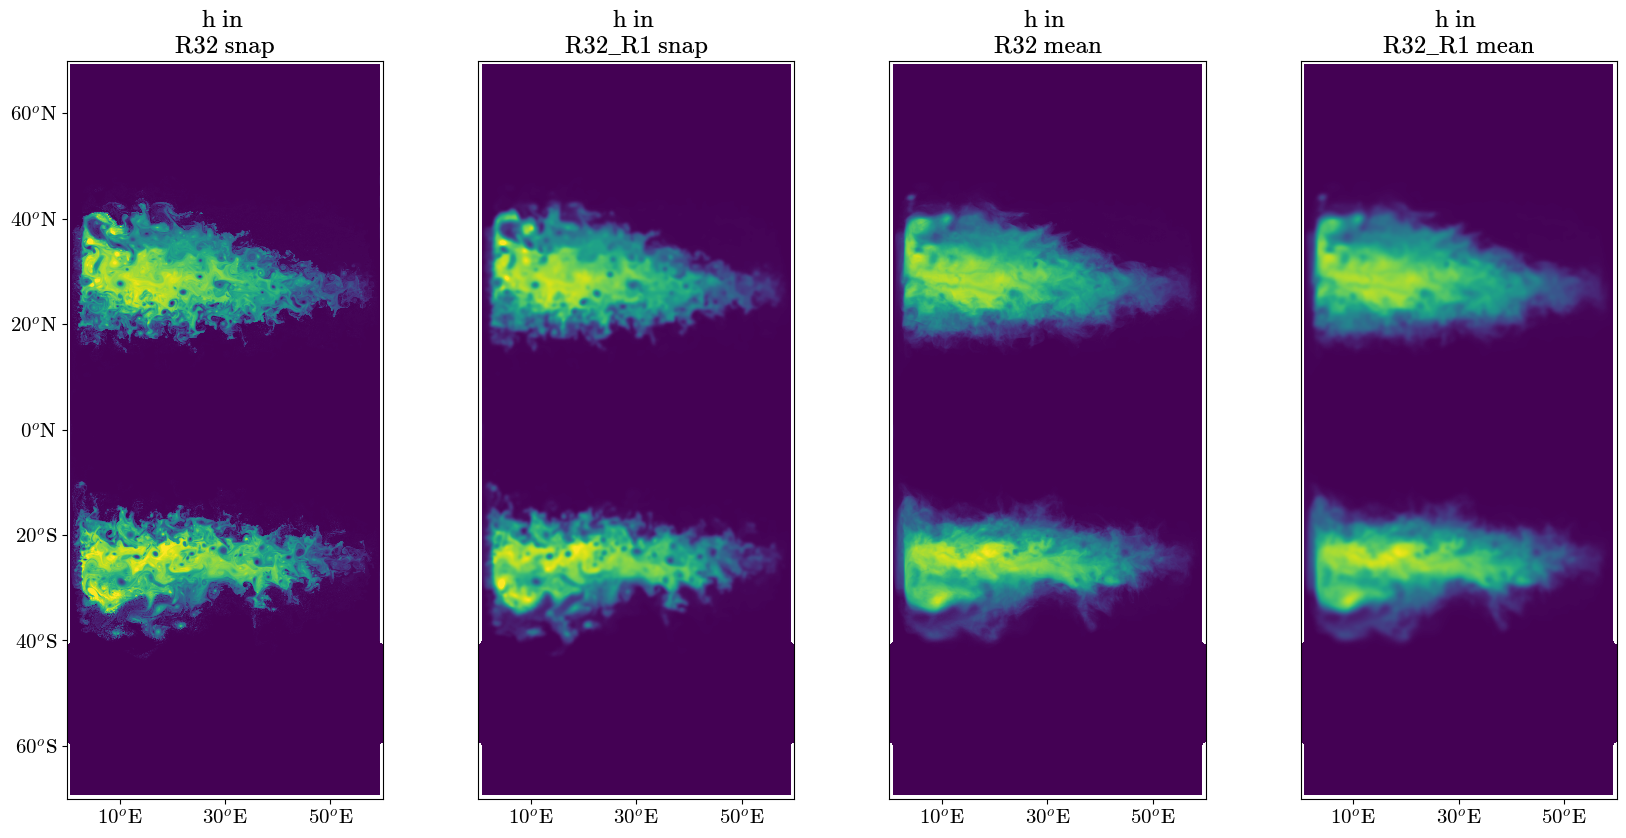

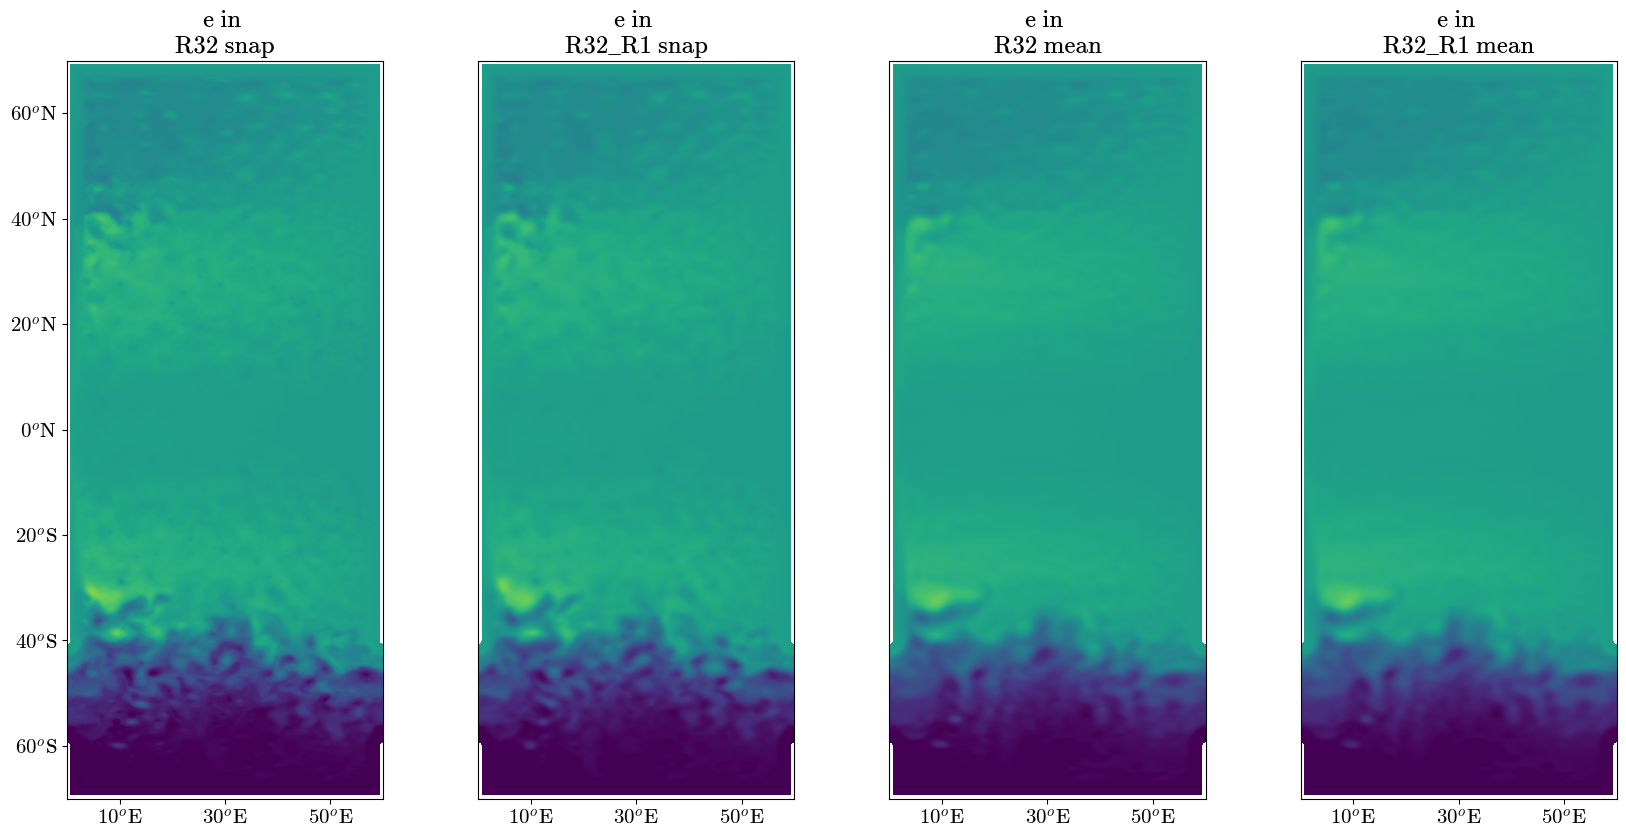

In [25]:
default_rcParams({'font.size': 15})
for key, clim in zip(
        ['u', 'v', 'h', 'e'],
        [(-1.5,1.5), (-1.5, 1.5), (0,200), (-3,3)]
    ):
    plt.figure(figsize=(20,10))
    zl = 'zl' if 'zl' in R32[key].dims else 'zi'
    for col, (exp,label) in enumerate(zip(
            [R32, R32f, M32, M32f], 
            ['R32 snap', 'R32_R1 snap', 'R32 mean', 'R32_R1 mean']
        )):
        plt.subplot(1,4,col+1)
        exp[key].isel({zl: 0}).plot(add_colorbar=False, vmin=clim[0], vmax=clim[1])
        plt.title(f'{key} in \n{label}')
        
        plt.gca().axes.set_aspect('equal')
        plt.xlabel('')
        plt.ylabel('')
        lons = [10,30,50]
        plt.xticks(lons, [f'${lon}^o$E' for lon in lons])
        if col==0:
            lats = [-60, -40, -20, 0, 20, 40, 60]
            lat_ticks = [f'${-lat}^o$S' if lat<0 else f'${lat}^o$N' for lat in lats]
            plt.yticks(lats, lat_ticks)
        else:
            plt.yticks([])